### ImagesClassificationWithSIFT with zca_whitening_parameter to False and featurewise_std_normalization_parameter to True

In [1]:
## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
# To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt

# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)


# import scipy as sio
# print("Scipy Version :"+sio.__version__)
import scipy.io as sio
import os
import shutil
import random
import cv2 as cv
print("OpenCV Version : "+cv.__version__)
from PIL import Image

# To be able to use Warning
import warnings
import sklearn
print("Sklearn Version : "+sklearn.__version__)
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier
import catboost
print("Catboost Version : "+catboost.__version__)
from catboost import CatBoostClassifier
# from utils import plot_confusion_matrix

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.applications import *
from keras.applications.xception import decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
import tensorflow as tf
print("Keras Version : "+tf.keras.__version__)
print("Tensorflow Version : "+tf.__version__)

Python Version :sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.5
Pandas Version :1.0.5
Seaborn Version :0.10.1
OpenCV Version : 3.4.2
Sklearn Version : 0.23.1
Catboost Version : 0.24


Using TensorFlow backend.


Keras Version : 2.2.4-tf
Tensorflow Version : 2.1.0


In [2]:
images_directory = './images/Images/'
# train_contents = sio.loadmat('./lists/train_list.mat')
# test_contents = sio.loadmat('./lists/test_list.mat')
# file_list = sio.loadmat('./lists/file_list.mat')
train_directory = './images/train/'
test_directory = './images/test/'

### Rename the folder names

In [ ]:
def convert(word):
    return ''.join(x.capitalize() or '_' for x in word.split('_'))

In [ ]:
for root, dirs, files in os.walk(images_directory):
    for count in dirs:
        print(convert(count.split('-')[1].capitalize()))
        os.rename(os.path.join(images_directory, count), os.path.join(images_directory, convert(count.split('-')[1].capitalize())))


### Creation of the  train test directory

In [ ]:
train_dir = './images/train/'
test_dir = './images/test/'


In [ ]:
files = [file for file in os.listdir(images_directory) if os.path.isfile(os.path.join(images_directory, file))]

In [ ]:
directories = [directory for directory in os.listdir(images_directory)]

In [ ]:
directories

In [ ]:
for directory in directories:
    os.mkdir(train_dir+directory)
    os.mkdir(test_dir+directory)

### Split train test

In [ ]:
directories

In [ ]:
for directory in directories:
    files = [file for file in os.listdir(images_directory+directory) if os.path.isfile(os.path.join(images_directory+directory, file))]
    train_count  = np.round(70/100*len(files))
    test_count = np.round(30/100*len(files))
    rndnums = list(random.sample(range(0, len(files)), len(files)))
    print("len(files)",len(files))
    train_file_index = rndnums[0:int(train_count)+1]
    train_file_name = [files[i] for i in train_file_index]
    test_file_index = rndnums[int(train_count)+1:int(train_count + test_count)+1]
    test_file_name = [files[i] for i in test_file_index]
    for x in train_file_name:
        file = x
        shutil.copyfile(os.path.join(images_directory+directory, file), os.path.join(train_directory+directory, file))
    ##test_files
    for y in test_file_name:
        file = y
        shutil.copyfile(os.path.join(images_directory+directory, file), os.path.join(test_directory+directory, file))

    

In [ ]:
train_file_name

In [3]:
input_directory='./images/'
output_directory='./new_images/'
small_directory_names = [directory for directory in os.listdir(input_directory+'train-small')]
small_directory_names.sort()
zca_whitening_parameter=False
featurewise_std_normalization_parameter=True
color_mode_parameter='grayscale'
save_prefix_parameter='set1_'
batch_size=2
follow_links=True
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zca_whitening=zca_whitening_parameter,
        featurewise_std_normalization=featurewise_std_normalization_parameter
        )

/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [4]:
small_directory_names

['Basset', 'Cardigan', 'OldEnglishSheepdog']

In [5]:
myCategories = dict(enumerate(small_directory_names))

In [6]:
myCategories

{0: 'Basset', 1: 'Cardigan', 2: 'OldEnglishSheepdog'}

In [7]:
train_generator = train_datagen.flow_from_directory(input_directory+'train-small', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, subset='training', shuffle=False, color_mode=color_mode_parameter)

Found 350 images belonging to 3 classes.


In [8]:
test_generator = train_datagen.flow_from_directory(input_directory+'test-small', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, shuffle=False, color_mode=color_mode_parameter)

Found 148 images belonging to 3 classes.


In [9]:
train_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

In [10]:
test_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

### Compute the descriptors  and add them with the category into a dataframe

In [11]:
algo_constructor = cv.xfeatures2d.SIFT_create()
def computeDescriptors(mygenerator, mydf, mydescriptors):
    count = 0
    for i in range(len(mygenerator)):
    #next(train_generator)
        for j in range(batch_size):
            img = mygenerator[i][0][j].squeeze()
            imgwithrgb = cv.merge([img, img, img])
            image8bit = cv.normalize(imgwithrgb, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
            keypoints, descriptors = algo_constructor.detectAndCompute(image8bit, None)
            mydf = mydf.append({'Category': mygenerator[i][1][j].tolist().index(1), 'Picture':image8bit, 'Descriptors':descriptors, 'NumberOfDescriptors':descriptors.shape[0]}, ignore_index='True')
            mydescriptors.extend(descriptors)
            count = count + 1
            j = j+1
    i = i+1
    mydf['Category'] = mydf['Category'].map(myCategories) 
    return mydf, mydescriptors

### Train 

In [12]:
train_descriptors_array=[]
train_df, train_descriptors_array=computeDescriptors(train_generator, train_df, train_descriptors_array)

/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


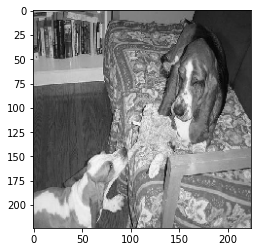

In [13]:
plt.imshow(train_df['Picture'][0])
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(60, 12))
axs[0].set_title('An Original Picture in grayscale  ', fontsize=20)
axs[0].imshow(train_df['Picture'][0], cmap='Greys_r')
axs[1].set_title('Histogram of an original Picture in grayscale ', fontsize=20)
axs[1].set_xlabel('Level of gray', fontsize=20)
axs[1].set_ylabel('Number of pixels', fontsize=20)
axs[1].hist(train_df['Picture'][0].ravel(), 256, [0, 256])


### Test

In [14]:
test_descriptors_array=[]
test_df, test_descriptors_array=computeDescriptors(test_generator, test_df, test_descriptors_array)

In [15]:
print(train_df['NumberOfDescriptors'].sum())

113360


In [16]:
print(test_df['NumberOfDescriptors'].sum())

46444


### Apply a Kmeans to get clusters

In [17]:
# A k-means clustering algorithm who takes 2 parameter which is number
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, descriptor_list):
    # kmeans = KMeans(n_clusters=k, n_init=10)
    mymodel = MiniBatchKMeans(n_clusters=k, n_init=10)
    mymodel.fit(descriptor_list)
    visual_words = mymodel.cluster_centers_
    labels = mymodel.labels_
    silhouette_score = metrics.silhouette_score(descriptor_list, labels)
    calinski_harabasz_score = metrics.calinski_harabasz_score(descriptor_list, labels)
    print('silhouette_score '+str(silhouette_score))
    print('calinski_harabasz_score '+str(calinski_harabasz_score))
    return mymodel, visual_words, labels
# Takes the central points which is visual words
model, visual_words, labels = kmeans(150, train_descriptors_array)

silhouette_score 0.024541032
calinski_harabasz_score 557.4013361785821


In [18]:
X_train = pd.DataFrame(columns=range(len(visual_words)))
X_test = pd.DataFrame(columns=range(len(visual_words)))

In [19]:
for index, row in train_df.iterrows():
    labels = model.predict(pd.DataFrame(row["Descriptors"]).astype(float))
    unique, counts = np.unique(labels, return_counts=True)
    X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)

In [20]:
X_train.fillna(0, inplace=True)

In [21]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,3.0,8.0,1.0,4.0,10.0,2.0,1.0,1.0,6.0,6.0,...,0.0,2.0,1.0,4.0,6.0,1.0,9.0,8.0,3.0,0.0
1,0.0,1.0,0.0,4.0,0.0,2.0,0.0,0.0,2.0,3.0,...,0.0,2.0,1.0,0.0,0.0,1.0,3.0,4.0,1.0,0.0
2,4.0,4.0,0.0,1.0,4.0,4.0,3.0,6.0,3.0,7.0,...,2.0,2.0,6.0,2.0,4.0,1.0,1.0,1.0,2.0,2.0
3,3.0,4.0,0.0,2.0,8.0,3.0,0.0,2.0,2.0,2.0,...,1.0,2.0,7.0,4.0,4.0,1.0,0.0,3.0,0.0,0.0
4,3.0,1.0,0.0,1.0,10.0,2.0,0.0,4.0,0.0,7.0,...,0.0,4.0,2.0,3.0,1.0,0.0,4.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2.0,1.0,2.0,0.0,1.0,4.0,2.0,2.0,0.0,2.0,...,0.0,6.0,1.0,3.0,2.0,2.0,1.0,5.0,1.0,3.0
346,2.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,0.0,2.0,...,0.0,13.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0
347,2.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,...,2.0,1.0,1.0,0.0,2.0,1.0,3.0,13.0,1.0,1.0
348,1.0,3.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,...,1.0,6.0,1.0,4.0,2.0,0.0,1.0,7.0,0.0,1.0


In [ ]:
train_df

### TSNE

In [22]:
X_train_embedded = TSNE(n_components=2).fit_transform(X_train)
X_train_embedded_df = pd.DataFrame(X_train_embedded, columns=['SIFT1', 'SIFT2'])

In [23]:
X_train_embedded_df['Category'] = train_df['Category']

silhouette_score -0.026827976
calinski_harabasz_score 3.0032992730556036


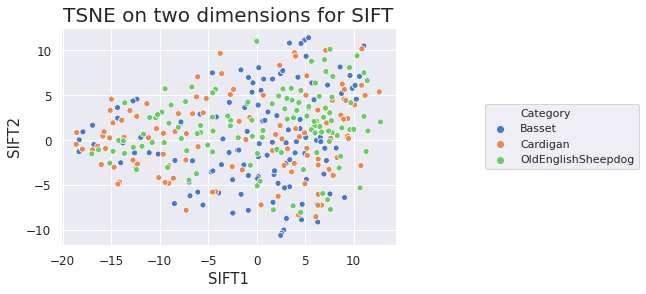

In [24]:
sns.set(palette='muted', color_codes=True, style='darkgrid')
ax = sns.scatterplot(x='SIFT1', y='SIFT2', hue="Category", data=X_train_embedded_df)
ax.set_title('TSNE on two dimensions for SIFT', fontsize=20)
ax.set_xlabel('SIFT1', fontsize=15)
ax.set_ylabel('SIFT2', fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax.tick_params(labelsize=12)
silhouette_score = metrics.silhouette_score(X_train_embedded, train_df['Category'])
calinski_harabasz_score = metrics.calinski_harabasz_score(X_train_embedded, train_df['Category'])
print('silhouette_score '+str(silhouette_score))
print('calinski_harabasz_score '+str(calinski_harabasz_score))

In [25]:
for index, row in test_df.iterrows():
    labels = model.predict(pd.DataFrame(row["Descriptors"]).astype(float))
    unique, counts = np.unique(labels, return_counts=True)
    X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)

In [26]:
X_test.fillna(0, inplace=True)

In [27]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,1.0,3.0,0.0,1.0,0.0,4.0,0.0,7.0,0.0,2.0,...,4.0,9.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0
1,3.0,5.0,1.0,0.0,0.0,2.0,2.0,3.0,1.0,0.0,...,2.0,1.0,8.0,1.0,1.0,3.0,0.0,8.0,2.0,1.0
2,1.0,1.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,4.0,...,2.0,4.0,2.0,1.0,1.0,1.0,4.0,6.0,3.0,1.0
3,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,4.0,...,0.0,0.0,2.0,1.0,2.0,0.0,2.0,4.0,0.0,5.0
4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,...,0.0,4.0,0.0,1.0,1.0,0.0,3.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,3.0,...,2.0,9.0,0.0,0.0,2.0,0.0,7.0,0.0,1.0,13.0
144,4.0,2.0,2.0,2.0,2.0,2.0,5.0,4.0,2.0,5.0,...,0.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0
145,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,...,0.0,5.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,2.0
146,3.0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,4.0,10.0,...,4.0,8.0,2.0,3.0,1.0,1.0,3.0,5.0,0.0,2.0


In [28]:
le = LabelEncoder().fit(train_df['Category'])

In [29]:
y_train = le.transform(train_df['Category'])
y_test = le.transform(test_df['Category'])

In [30]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### CatBoostClassifier 

In [31]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

In [32]:
clf.fit(
    X_train, y_train
    # cat_features=[0, 1, 2]
)

0:	learn: 1.0834980	total: 70.2ms	remaining: 1m 10s
1:	learn: 1.0653105	total: 75.3ms	remaining: 37.6s
2:	learn: 1.0568771	total: 79ms	remaining: 26.3s
3:	learn: 1.0415939	total: 82.2ms	remaining: 20.5s
4:	learn: 1.0284352	total: 85.4ms	remaining: 17s
5:	learn: 1.0167244	total: 89.1ms	remaining: 14.8s
6:	learn: 1.0023067	total: 91.8ms	remaining: 13s
7:	learn: 0.9896294	total: 95.1ms	remaining: 11.8s
8:	learn: 0.9793363	total: 97.7ms	remaining: 10.8s
9:	learn: 0.9659613	total: 100ms	remaining: 9.95s
10:	learn: 0.9563762	total: 103ms	remaining: 9.3s
11:	learn: 0.9459009	total: 106ms	remaining: 8.75s
12:	learn: 0.9363210	total: 109ms	remaining: 8.28s
13:	learn: 0.9235822	total: 112ms	remaining: 7.87s
14:	learn: 0.9153945	total: 115ms	remaining: 7.54s
15:	learn: 0.9047362	total: 121ms	remaining: 7.46s
16:	learn: 0.8932211	total: 133ms	remaining: 7.68s
17:	learn: 0.8803136	total: 138ms	remaining: 7.55s
18:	learn: 0.8737353	total: 142ms	remaining: 7.33s
19:	learn: 0.8662568	total: 145ms	rema

184:	learn: 0.1865257	total: 856ms	remaining: 3.77s
185:	learn: 0.1856258	total: 861ms	remaining: 3.77s
186:	learn: 0.1843585	total: 865ms	remaining: 3.76s
187:	learn: 0.1830598	total: 877ms	remaining: 3.79s
188:	learn: 0.1814146	total: 892ms	remaining: 3.83s
189:	learn: 0.1806888	total: 914ms	remaining: 3.89s
190:	learn: 0.1791079	total: 919ms	remaining: 3.89s
191:	learn: 0.1782498	total: 948ms	remaining: 3.99s
192:	learn: 0.1769687	total: 953ms	remaining: 3.99s
193:	learn: 0.1755539	total: 956ms	remaining: 3.97s
194:	learn: 0.1738494	total: 959ms	remaining: 3.96s
195:	learn: 0.1728746	total: 963ms	remaining: 3.95s
196:	learn: 0.1717806	total: 966ms	remaining: 3.94s
197:	learn: 0.1709947	total: 968ms	remaining: 3.92s
198:	learn: 0.1693559	total: 971ms	remaining: 3.91s
199:	learn: 0.1681943	total: 974ms	remaining: 3.9s
200:	learn: 0.1671274	total: 977ms	remaining: 3.88s
201:	learn: 0.1660071	total: 979ms	remaining: 3.87s
202:	learn: 0.1648645	total: 981ms	remaining: 3.85s
203:	learn: 0

344:	learn: 0.0762759	total: 1.64s	remaining: 3.12s
345:	learn: 0.0759509	total: 1.65s	remaining: 3.12s
346:	learn: 0.0756700	total: 1.66s	remaining: 3.13s
347:	learn: 0.0753791	total: 1.67s	remaining: 3.13s
348:	learn: 0.0750050	total: 1.68s	remaining: 3.13s
349:	learn: 0.0748084	total: 1.68s	remaining: 3.13s
350:	learn: 0.0744586	total: 1.69s	remaining: 3.13s
351:	learn: 0.0740800	total: 1.71s	remaining: 3.14s
352:	learn: 0.0737964	total: 1.73s	remaining: 3.17s
353:	learn: 0.0734963	total: 1.75s	remaining: 3.19s
354:	learn: 0.0731851	total: 1.75s	remaining: 3.19s
355:	learn: 0.0729895	total: 1.76s	remaining: 3.18s
356:	learn: 0.0726815	total: 1.76s	remaining: 3.17s
357:	learn: 0.0723651	total: 1.76s	remaining: 3.17s
358:	learn: 0.0720384	total: 1.77s	remaining: 3.16s
359:	learn: 0.0718667	total: 1.77s	remaining: 3.15s
360:	learn: 0.0715727	total: 1.78s	remaining: 3.15s
361:	learn: 0.0712829	total: 1.78s	remaining: 3.14s
362:	learn: 0.0709652	total: 1.78s	remaining: 3.13s
363:	learn: 

519:	learn: 0.0421754	total: 3.03s	remaining: 2.8s
520:	learn: 0.0420538	total: 3.04s	remaining: 2.79s
521:	learn: 0.0419272	total: 3.05s	remaining: 2.79s
522:	learn: 0.0418480	total: 3.06s	remaining: 2.79s
523:	learn: 0.0417464	total: 3.06s	remaining: 2.78s
524:	learn: 0.0416550	total: 3.08s	remaining: 2.78s
525:	learn: 0.0415464	total: 3.08s	remaining: 2.78s
526:	learn: 0.0414436	total: 3.09s	remaining: 2.78s
527:	learn: 0.0413154	total: 3.1s	remaining: 2.77s
528:	learn: 0.0411951	total: 3.12s	remaining: 2.78s
529:	learn: 0.0410472	total: 3.13s	remaining: 2.77s
530:	learn: 0.0409450	total: 3.14s	remaining: 2.77s
531:	learn: 0.0408162	total: 3.15s	remaining: 2.77s
532:	learn: 0.0406914	total: 3.16s	remaining: 2.77s
533:	learn: 0.0405817	total: 3.16s	remaining: 2.76s
534:	learn: 0.0404741	total: 3.17s	remaining: 2.75s
535:	learn: 0.0403724	total: 3.17s	remaining: 2.75s
536:	learn: 0.0402605	total: 3.17s	remaining: 2.74s
537:	learn: 0.0401670	total: 3.18s	remaining: 2.73s
538:	learn: 0.

684:	learn: 0.0283846	total: 4.74s	remaining: 2.18s
685:	learn: 0.0283275	total: 4.75s	remaining: 2.17s
686:	learn: 0.0282586	total: 4.76s	remaining: 2.17s
687:	learn: 0.0282092	total: 4.78s	remaining: 2.17s
688:	learn: 0.0281366	total: 4.79s	remaining: 2.16s
689:	learn: 0.0280852	total: 4.81s	remaining: 2.16s
690:	learn: 0.0280228	total: 4.82s	remaining: 2.16s
691:	learn: 0.0279516	total: 4.83s	remaining: 2.15s
692:	learn: 0.0279123	total: 4.84s	remaining: 2.15s
693:	learn: 0.0278556	total: 4.85s	remaining: 2.14s
694:	learn: 0.0278134	total: 4.86s	remaining: 2.13s
695:	learn: 0.0277602	total: 4.87s	remaining: 2.13s
696:	learn: 0.0277021	total: 4.88s	remaining: 2.12s
697:	learn: 0.0276523	total: 4.9s	remaining: 2.12s
698:	learn: 0.0275949	total: 4.91s	remaining: 2.12s
699:	learn: 0.0275376	total: 4.93s	remaining: 2.11s
700:	learn: 0.0274813	total: 4.94s	remaining: 2.11s
701:	learn: 0.0274298	total: 4.95s	remaining: 2.1s
702:	learn: 0.0273562	total: 4.98s	remaining: 2.1s
703:	learn: 0.0

853:	learn: 0.0210051	total: 6.36s	remaining: 1.09s
854:	learn: 0.0209701	total: 6.37s	remaining: 1.08s
855:	learn: 0.0209460	total: 6.37s	remaining: 1.07s
856:	learn: 0.0209165	total: 6.38s	remaining: 1.06s
857:	learn: 0.0208863	total: 6.39s	remaining: 1.06s
858:	learn: 0.0208569	total: 6.41s	remaining: 1.05s
859:	learn: 0.0208152	total: 6.42s	remaining: 1.04s
860:	learn: 0.0207894	total: 6.43s	remaining: 1.04s
861:	learn: 0.0207542	total: 6.43s	remaining: 1.03s
862:	learn: 0.0207197	total: 6.44s	remaining: 1.02s
863:	learn: 0.0206907	total: 6.45s	remaining: 1.01s
864:	learn: 0.0206652	total: 6.45s	remaining: 1.01s
865:	learn: 0.0206339	total: 6.46s	remaining: 1s
866:	learn: 0.0206160	total: 6.47s	remaining: 993ms
867:	learn: 0.0205817	total: 6.48s	remaining: 985ms
868:	learn: 0.0205552	total: 6.49s	remaining: 978ms
869:	learn: 0.0205276	total: 6.49s	remaining: 970ms
870:	learn: 0.0204942	total: 6.5s	remaining: 962ms
871:	learn: 0.0204491	total: 6.5s	remaining: 955ms
872:	learn: 0.020

In [33]:
y_pred = clf.predict(data=X_test)

In [34]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,1.0,3.0,0.0,1.0,0.0,4.0,0.0,7.0,0.0,2.0,...,4.0,9.0,0.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0
1,3.0,5.0,1.0,0.0,0.0,2.0,2.0,3.0,1.0,0.0,...,2.0,1.0,8.0,1.0,1.0,3.0,0.0,8.0,2.0,1.0
2,1.0,1.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,4.0,...,2.0,4.0,2.0,1.0,1.0,1.0,4.0,6.0,3.0,1.0
3,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,4.0,...,0.0,0.0,2.0,1.0,2.0,0.0,2.0,4.0,0.0,5.0
4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,...,0.0,4.0,0.0,1.0,1.0,0.0,3.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,3.0,...,2.0,9.0,0.0,0.0,2.0,0.0,7.0,0.0,1.0,13.0
144,4.0,2.0,2.0,2.0,2.0,2.0,5.0,4.0,2.0,5.0,...,0.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0
145,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,...,0.0,5.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,2.0
146,3.0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,4.0,10.0,...,4.0,8.0,2.0,3.0,1.0,1.0,3.0,5.0,0.0,2.0


### Results

----- Accuracy: 57.43 % -----


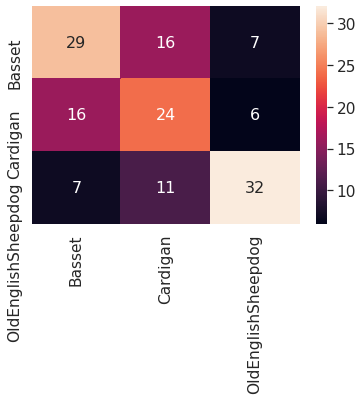

In [35]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), small_directory_names, small_directory_names)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()